In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import random
random.seed(42)

import torch
from torch.nn import functional as F
torch.manual_seed(42)

from model import NGram

import sys
sys.path.insert(0, "..")
from preprocessing import get_data, load_split_data

%matplotlib inline

## Load Data


In [ ]:
block_size = 3
words, stoi, itos = get_data()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = load_split_data(words, stoi, block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
def cross_entropy(logits, Y):
    logits = (
        logits - logits.max(1, keepdim=True).values
    )  # so exp doesn't overflow 2 inf
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdim=True)
    loss = -prob[torch.arange(len(logits)), Y].log().mean()
    return loss

## Train


In [ ]:
batch_size = 32
n_iters = 100_000
lr = 0.1

m = NGram()
losses = []


def train(m, X, Y, n_iters, batch_size):
    losses = []
    for i in range(n_iters):
        # mini-batch
        ix = torch.randint(0, len(X), (batch_size,))
        logits = m.forward(X[ix])

        loss = cross_entropy(logits, Ytr[ix])
        losses.append(loss.item())  # mini-batch loss

        if i % 20_000 == 0:
            print(loss.item())

        for p in m.parameters:
            p.grad = None

        loss.backward()

        for p in m.parameters:
            p.data += -lr * p.grad
    return losses

no.of paramters: 3581


In [ ]:
losses += train(m, Xtr, Ytr, 1, batch_size)
losses

3.2996068000793457


[3.2996068000793457]

3.2668607234954834
2.774171829223633
2.186072826385498
2.3818604946136475
2.2348263263702393


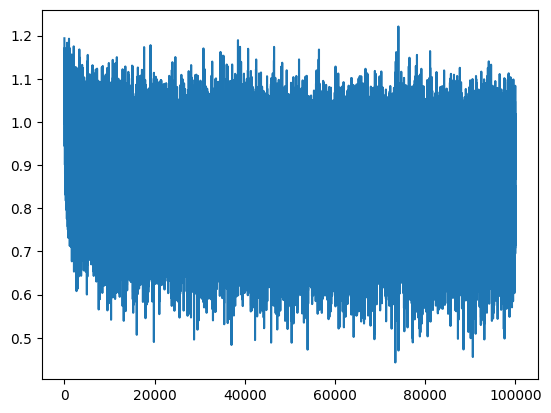

In [ ]:
losses += train(m, Xtr, Ytr, n_iters, batch_size)
plt.plot(range(len(losses)), np.log(losses))

### Total loss


In [ ]:
logits = m.predict(Xtr)
loss = cross_entropy(logits, Ytr)
loss

tensor(2.2874, grad_fn=<NegBackward0>)

In [ ]:
logits = m.predict(Xdev)
loss = cross_entropy(logits, Ydev)
loss

tensor(2.2889, grad_fn=<NegBackward0>)

In [ ]:
def predict(n=10):
    for i in range(n):
        out = []
        context = [0] * 3
        while True:
            logits = m.predict(context)
            probs = F.softmax(logits, 1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break
        print("".join(out))


predict()

jallohariel.
alneazoilynncn.
len.
keniel.
joe.
siaj.
eponi.
iquy.
jaeyanthoom.
sailyn.
